In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBRFClassifier, XGBClassifier, XGBRegressor
import random 
import time 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb

random.seed(2021)
np.random.seed(2021)

from experiments.exp_linear import *

# Fixed the seed and plot env
random.seed(1)
np.random.seed(1)

plt.style.use(['ggplot'])

# Create synthetic data and train RandomForest

In [2]:
p = 0.7
n = 10000
d = 3
mean = np.zeros(d)
# Determinitist covariance
cov = p*np.ones(shape=(d, d)) - (p - 1)*np.eye(d)
C = [[]]

# Random covariance
# b = np.random.randn(d, d)
# cov = np.dot(b, b.T)

# covariance
coefs = 4*np.random.randn(d)
model_type = 'linear'
k = 2
coefs[k:] = 0

exp = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n, C=C)
data = exp.data
print('Coefficients of the Linear regression are = {}'.format(coefs))

Coefficients of the Linear regression are = [ 6.49738145 -2.44702565  0.        ]


In [3]:
# model = XGBRegressor()
model = RandomForestRegressor(n_estimators=1)
model.fit(exp.data, exp.y_train)

print('TEST SET MSE Withou Discretization = {}'.format(mean_squared_error(model.predict(exp.data_test), exp.y_test)))

TEST SET MSE Withou Discretization = 0.087192708328192


# Discritized the Data (nb of quantile = 9)

In [4]:
columns_name = ['X{}'.format(i) for i in range(d)]
data = pd.DataFrame(exp.data, columns=columns_name)
data_test = pd.DataFrame(exp.data_test, columns=columns_name)
data_test.head()

,X0,X1,X2
0,1.318085,-1.232146,0.859148
1,-1.045707,-0.514316,-0.938388
2,0.151569,0.939997,0.153231
3,-0.307866,0.158282,-0.042149
4,0.935535,2.141554,0.398498


In [5]:
q = 9

data_cat, q_values = quantile_discretizer(data, q, [])
data_cat.head()

data_cat_test = quantile_discretizer_byq(data_test, [], q_values)
data_cat_test.columns = data_cat.columns 
data_cat_test.head()

,X0: q0.0-q0.12,X0: q0.12-q0.25,X0: q0.25-q0.38,X0: q0.38-q0.5,X0: q0.5-q0.62,X0: q0.62-q0.75,X0: q0.75-q0.88,X0: q0.88-q1.0,X1: q0.0-q0.12,X1: q0.12-q0.25,...,X1: q0.75-q0.88,X1: q0.88-q1.0,X2: q0.0-q0.12,X2: q0.12-q0.25,X2: q0.25-q0.38,X2: q0.38-q0.5,X2: q0.5-q0.62,X2: q0.62-q0.75,X2: q0.75-q0.88,X2: q0.88-q1.0
0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [6]:
# model_cat = XGBRegressor()
model_cat = RandomForestRegressor(n_estimators=1, max_depth=8)
model_cat.fit(data_cat, exp.y_train)

print('TEST SET MSE = {}'.format(mean_squared_error(model_cat.predict(data_cat_test), exp.y_test)))

TEST SET MSE = 2.8800937779490066


# Build ACVTree

In [7]:
acvtree_cat = ACVTree(model_cat, data_cat.values)

100%|██████████| 1/1 [00:00<00:00, 54.29it/s]


In [8]:
# Tree SHAP with coalition

def shap_exp(tree, S, x):
    tree_ind = 0

    def R(node_ind):

        f = tree.features[tree_ind, node_ind]
        lc = tree.children_left[tree_ind, node_ind]
        rc = tree.children_right[tree_ind, node_ind]
        if lc < 0:
            return tree.values[tree_ind, node_ind]
        if f in S:
            if x[f] <= tree.thresholds[tree_ind, node_ind]:
                return R(lc)
            return R(rc)
        lw = tree.node_sample_weight[tree_ind, lc]
        rw = tree.node_sample_weight[tree_ind, rc]
        return (R(lc) * lw + R(rc) * rw) / (lw + rw)

    out = 0.0
    l = tree.values.shape[0] if tree.tree_limit is None else tree.tree_limit
    for i in range(l):
        tree_ind = i
        out += R(0)
    return out

def shap_cond_exp(X, S, tree):
    cond = np.zeros((X.shape[0], tree.values.shape[2]))
    for i in range(X.shape[0]):
        cond[i] = shap_exp(x=X[i], S=S, tree=tree)
    return cond

def tree_shap_cat(X, C, tree):
    N = X.shape[0]
    m = X.shape[1]
    va_id = list(range(m))
    va_buffer = va_id.copy()
    
    if C[0] != []:
        for c in C:
            m -= len(c)
            va_id = list(set(va_id) - set(c))
        m += len(C)
        for c in C:
            va_id += [c]

    phi = np.zeros(shape=(X.shape[0], X.shape[1], tree.values.shape[2]))

    for i in tqdm(va_id):
        Sm = list(set(va_buffer) - set(convert_list(i)))

        if C[0] != []:
            buffer_Sm = Sm.copy()
            for c in C:
                if set(c).issubset(buffer_Sm):
                    Sm = list(set(Sm) - set(c))
            for c in C:
                if set(c).issubset(buffer_Sm):
                    Sm += [c]

        for S in powerset(Sm):
            weight = comb(m - 1, len(S)) ** (-1)
            v_plus = shap_cond_exp(X=X, S=np.array(chain_l(S) + convert_list(i)).astype(int), tree=tree)
            v_minus = shap_cond_exp(X=X, S=np.array(chain_l(S)).astype(int), tree=tree)

            for j in convert_list(i):
                phi[:, j] += weight * (v_plus - v_minus)

    return phi / m


## Sample data for explanations

In [9]:
n_gen = 100000
exp2 = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n_gen, C=C)

columns_name = ['X{}'.format(i) for i in range(d)]
data2 = pd.DataFrame(exp2.data, columns=columns_name)
data_test2 = pd.DataFrame(exp2.data_test, columns=columns_name)

data_cat2 = quantile_discretizer_byq(data2, [], q_values)
data_cat2.columns = data_cat.columns

data_cat_test2 = quantile_discretizer_byq(data_test2, [], q_values)
data_cat_test2.columns = data_cat.columns

data_gen = np.array(data2, dtype=np.float)
data_cat_gen = np.array(data_cat2, dtype=np.float)

data_cat_np = np.array(data_cat, dtype=np.float)
data_np = np.array(data, dtype=np.float)

In [10]:
# Uniform data
n_gen = 50000

columns_name = ['X{}'.format(i) for i in range(d)]
data_unif =  np.random.uniform(low=-10, high=10, size=n_gen*d)
data_unif = data_unif.reshape((n_gen, d))
data_unif = pd.DataFrame(data_unif, columns=columns_name)


data_cat_unif = quantile_discretizer_byq(data_unif, [], q_values)
data_cat_unif.columns = data_cat.columns

In [11]:
nb = 500
C = []
for i in range(d):
    c = []
    for j in range(q-1):
        c.append(i*(q-1) + j)
    C.append(c)

In [12]:
'Indices of the variables group together = {}'.format(C)

'Indices of the variables group together = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23]]'

## Compute SV with the different estimators

In [13]:
plug_sv = acvtree_cat.py_shap_values_discrete_notoptimized(data_cat_gen[:nb], C=C, data=data_cat.values.astype(float))

100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


In [14]:
plug_sv_leaf = acvtree_cat.py_shap_values_notoptimized(data_cat_gen[:nb], C=C, data=data_cat.values.astype(float))

100%|██████████| 3/3 [00:00<00:00,  9.65it/s]


In [15]:
q_arr = np.array(list(q_values.values()))
mc_sv = tree_sv_exact_discretized(data_cat_gen[:nb], acvtree_cat, q_arr, q_values, C, mean, cov, N=1000000)

100%|██████████| 3/3 [02:48<00:00, 56.08s/it]


In [16]:
shap_sv = tree_shap_cat(X=data_cat_gen[:nb], C=C, tree=acvtree_cat)

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


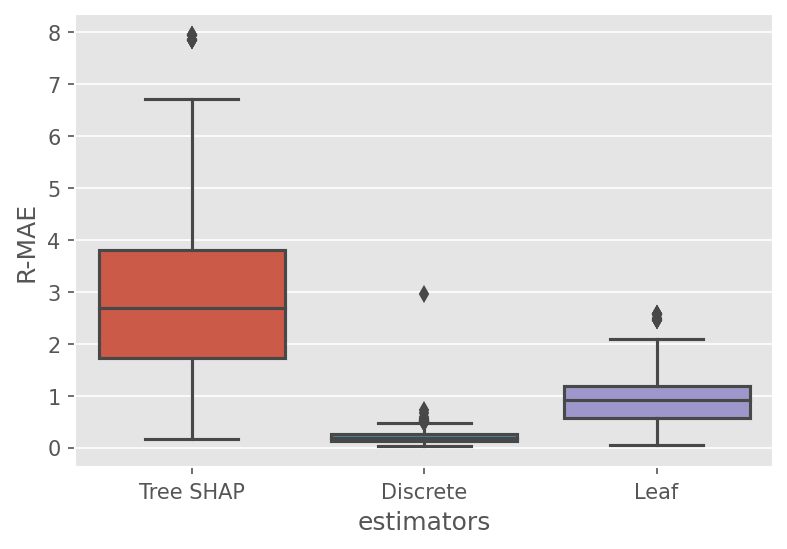

In [17]:
plug_sv = plug_sv.squeeze()
plug_sv_leaf = plug_sv_leaf.squeeze()
shap_sv = shap_sv.squeeze()
mc_sv = mc_sv.squeeze()
plug_sv_r = np.zeros(shape=mc_sv.shape)
shap_sv_r = np.zeros(shape=mc_sv.shape)
plug_sv_leaf_r = np.zeros(shape=mc_sv.shape)
for i in range(d):
    plug_sv_r[:, i] = plug_sv[:, C[i][0]]
    shap_sv_r[:, i] = shap_sv[:, C[i][0]]
    plug_sv_leaf_r[:, i] = plug_sv_leaf[:, C[i][0]]

sample_data = np.concatenate([shap_sv_r, plug_sv_r, plug_sv_leaf_r], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb * ['Tree SHAP'] + nb * ['Discrete'] + nb * ['Leaf']

relative = np.zeros(shape=mc_sv.shape)
for i in range(mc_sv.shape[0]):
    for j in range(mc_sv.shape[1]):
        if np.abs(mc_sv[i, j]) < 1:
            relative[i, j] = 1
        else:
            relative[i, j] = mc_sv[i, j]
            
err_monte_carlo = l1_norm((mc_sv- mc_sv)/relative)
err_plugin = l1_norm((plug_sv_r - mc_sv)/relative)
err_shap = l1_norm((shap_sv_r - mc_sv)/relative)
err_plugin_leaf = l1_norm((plug_sv_leaf_r - mc_sv)/relative)
err_concat = np.concatenate([err_shap, err_plugin, err_plugin_leaf], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [18]:
shap_dataFra.replace([np.inf, -np.inf], np.nan, inplace=True)
shap_dataFra.dropna(axis=0, inplace=True)
shap_dataFra.shape

(1500, 5)

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

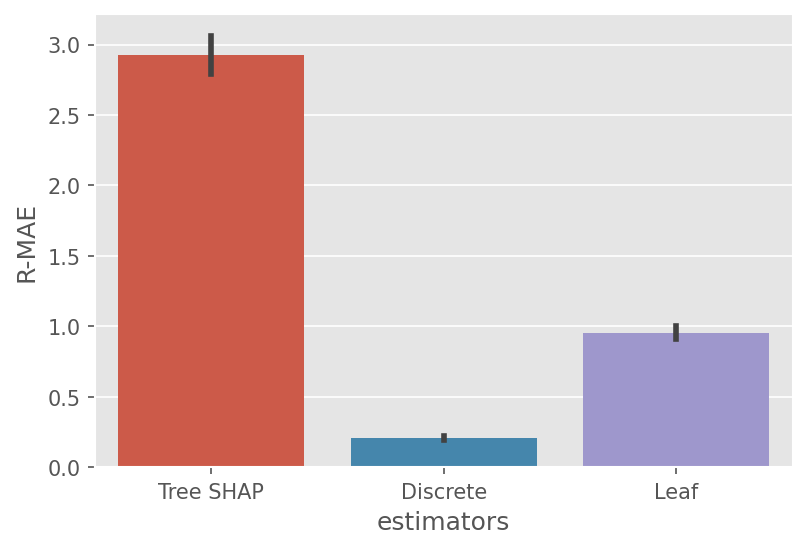

In [19]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [20]:
print('err_shap = {} -- err_plugin = {} - err_leaf = {}'.format(np.mean(err_shap), np.mean(err_plugin),
                                                                np.mean(err_plugin_leaf)))

err_shap = 2.927742478152098 -- err_plugin = 0.2067622873051523 - err_leaf = 0.9540416497730656


In [21]:
from experiments import utils

mc_sv = mc_sv.squeeze()
shap_sv = shap_sv_r.squeeze()
plug_sv = plug_sv_r.squeeze()
plug_sv_leaf = plug_sv_leaf_r.squeeze()

def return_fi(sv, k=1):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv)
fi_shap = return_fi(shap_sv)
fi_plug = return_fi(plug_sv)
fi_plug_leaf = return_fi(plug_sv_leaf)

In [22]:
print('SHAP - TPR - std TPR - FDE - std FDR')

utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(54.999999450000004, 49.74937135783728, 44.999999550000005, 49.74937135783728)

In [23]:
print('Discrete - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Discrete - TPR - std TPR - FDE - std FDR


(94.79999905200003, 22.202702316177643, 5.199999948, 22.20270231617765)

In [24]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug_leaf)

Leaf - TPR - std TPR - FDE - std FDR


(75.39999924600002, 43.06785301014204, 24.599999754000002, 43.067853010142045)

# Error on anomaly samples

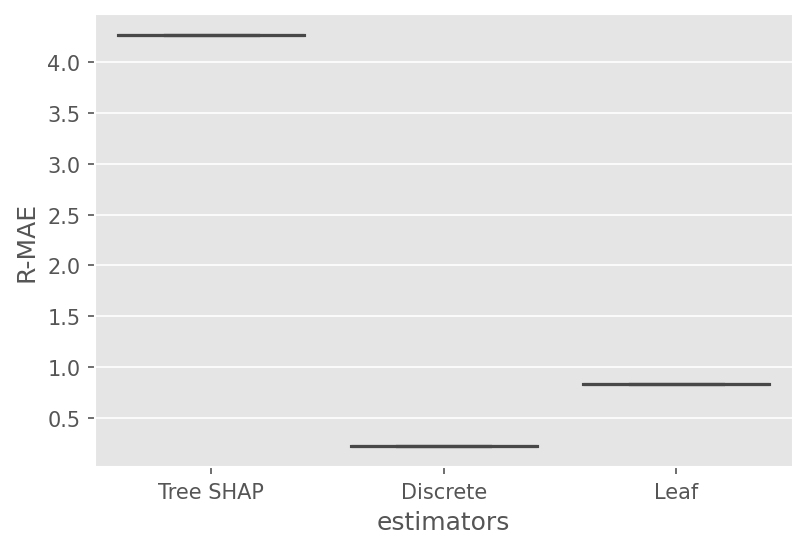

In [25]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(data_cat_gen)

ano_idx = clf.predict(data_cat_gen[:nb])
data_ano = data_cat_gen[:nb][ano_idx == -1]
nb_ano = np.sum(ano_idx == -1)

nb_ano = np.sum(ano_idx == -1)
idx = ano_idx==-1

sample_data = np.concatenate([shap_sv[idx], plug_sv[idx], plug_sv_leaf[idx]], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb_ano * ['Tree SHAP'] + nb_ano * ['Discrete'] + nb_ano * ['Leaf'] 

err_monte_carlo = l1_norm((mc_sv[idx]- mc_sv[idx])/relative[idx])
err_plugin = l1_norm((plug_sv[idx] - mc_sv[idx])/relative[idx])
err_plugin_leaf = l1_norm((plug_sv_leaf[idx] - mc_sv[idx])/relative[idx])
err_shap = l1_norm((shap_sv[idx] - mc_sv[idx])/relative[idx])
err_concat = np.concatenate([err_shap, err_plugin, err_plugin_leaf], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE')

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

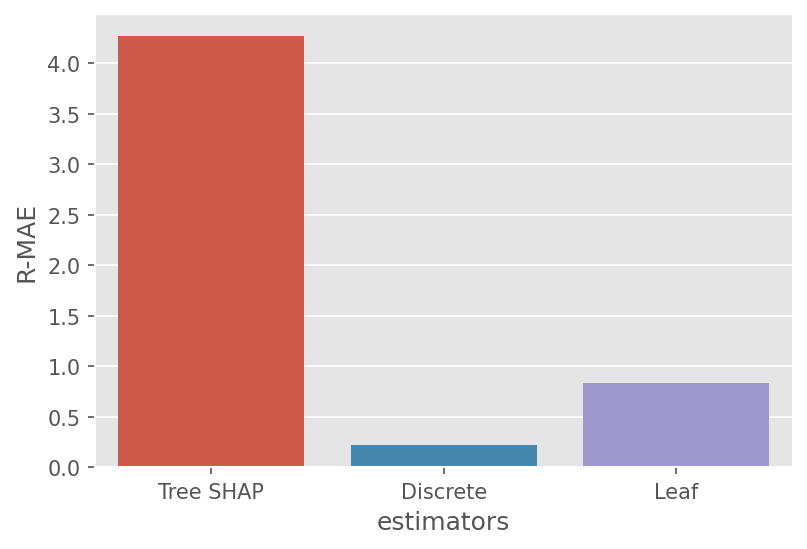

In [26]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [27]:
print('err_shap = {} -- err_plugin = {} - err_leaf = {}'.format(np.mean(err_shap), np.mean(err_plugin),
                                                                np.mean(err_plugin_leaf)))

err_shap = 4.2734048909741125 -- err_plugin = 0.21616604339707962 - err_leaf = 0.8311104002257286


In [28]:
def return_fi(sv, k=1):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv[idx])
fi_shap = return_fi(shap_sv[idx])
fi_plug = return_fi(plug_sv[idx])
fi_plug_leaf = return_fi(plug_sv_leaf[idx])

In [29]:
print('SHAP - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(0.0, 0.0, 99.99999900000002, 0.0)

In [30]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Leaf - TPR - std TPR - FDE - std FDR


(99.99999900000002, 0.0, 0.0, 0.0)

In [31]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug_leaf)

Leaf - TPR - std TPR - FDE - std FDR


(99.99999900000002, 0.0, 0.0, 0.0)

# Error on normal samples

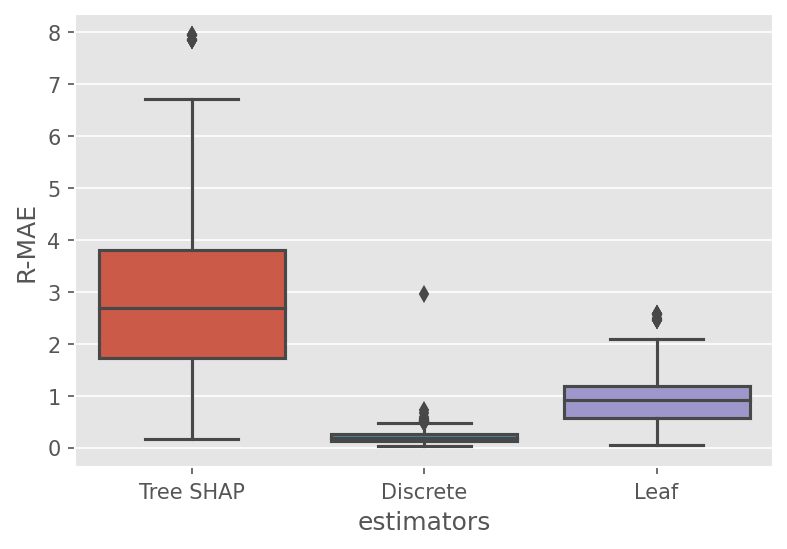

In [32]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(data_cat_gen)


nb_ano = np.sum(ano_idx == 1)
idx = ano_idx==1

sample_data = np.concatenate([shap_sv[idx], plug_sv[idx], plug_sv_leaf[idx]], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb_ano * ['Tree SHAP'] + nb_ano * ['Discrete'] + nb_ano * ['Leaf'] 

err_monte_carlo = l1_norm((mc_sv[idx]- mc_sv[idx])/relative[idx])
err_plugin = l1_norm((plug_sv[idx] - mc_sv[idx])/relative[idx])
err_plugin_leaf = l1_norm((plug_sv_leaf[idx] - mc_sv[idx])/relative[idx])
err_shap = l1_norm((shap_sv[idx] - mc_sv[idx])/relative[idx])
err_concat = np.concatenate([err_shap, err_plugin, err_plugin_leaf], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE')

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

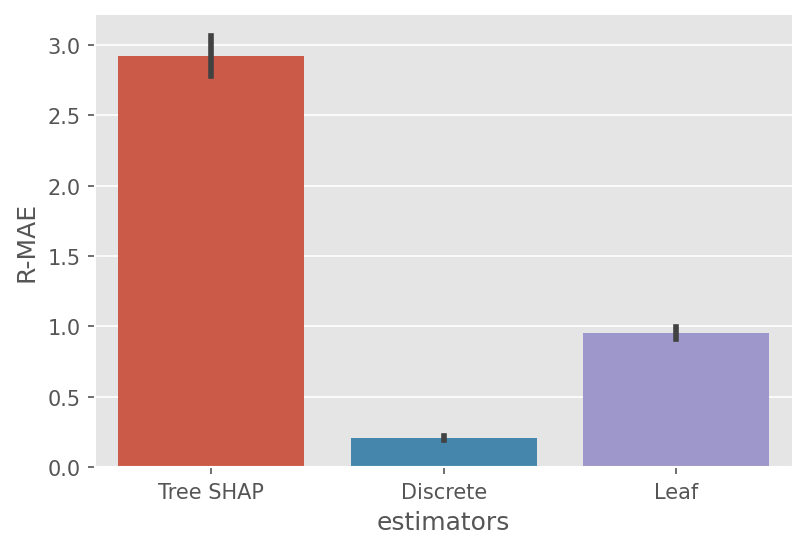

In [33]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [34]:
print('err_shap = {} -- err_plugin = {} - err_leaf = {}'.format(np.mean(err_shap), np.mean(err_plugin),
                                                                np.mean(err_plugin_leaf)))

err_shap = 2.92504575988993 -- err_plugin = 0.20674344210256326 - err_leaf = 0.9542880049825795


In [35]:
def return_fi(sv, k=1):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv[idx])
fi_shap = return_fi(shap_sv[idx])
fi_plug = return_fi(plug_sv[idx])
fi_plug_leaf = return_fi(plug_sv_leaf[idx])

In [36]:
print('SHAP - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(55.110219889779565, 49.73817042843336, 44.88977911022045, 49.73817042843336)

In [37]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Leaf - TPR - std TPR - FDE - std FDR


(94.78957821042087, 22.223716812068506, 5.2104207895791586, 22.22371681206851)

In [38]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug_leaf)

Leaf - TPR - std TPR - FDE - std FDR


(75.3507006492986, 43.09688969332882, 24.649298350701407, 43.09688969332881)

# Error on uniform samples

In [39]:
n_gen = 50000

columns_name = ['X{}'.format(i) for i in range(d)]
data_unif =  np.random.uniform(low=-10, high=10, size=n_gen*d)
data_unif = data_unif.reshape((n_gen, d))
data_unif = pd.DataFrame(data_unif, columns=columns_name)


data_cat_unif = quantile_discretizer_byq(data_unif, [], q_values)
data_cat_unif.columns = data_cat.columns

In [40]:
plug_sv = acvtree_cat.py_shap_values_discrete_notoptimized(data_cat_unif.values.astype(float)[:nb], C=C, data=data_cat.values.astype(float))

100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


In [41]:
plug_sv_leaf = acvtree_cat.py_shap_values_notoptimized(data_cat_unif.values.astype(float)[:nb], C=C, data=data_cat.values.astype(float))

100%|██████████| 3/3 [00:00<00:00, 13.27it/s]


In [42]:
q_arr = np.array(list(q_values.values()))
mc_sv = tree_sv_exact_discretized(data_cat_unif.values.astype(float)[:nb], acvtree_cat, q_arr, q_values, C, mean, cov, N=1000000)

100%|██████████| 3/3 [02:43<00:00, 54.67s/it]


In [43]:
shap_sv = tree_shap_cat(X=data_cat_unif.values.astype(float)[:nb], C=C, tree=acvtree_cat)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


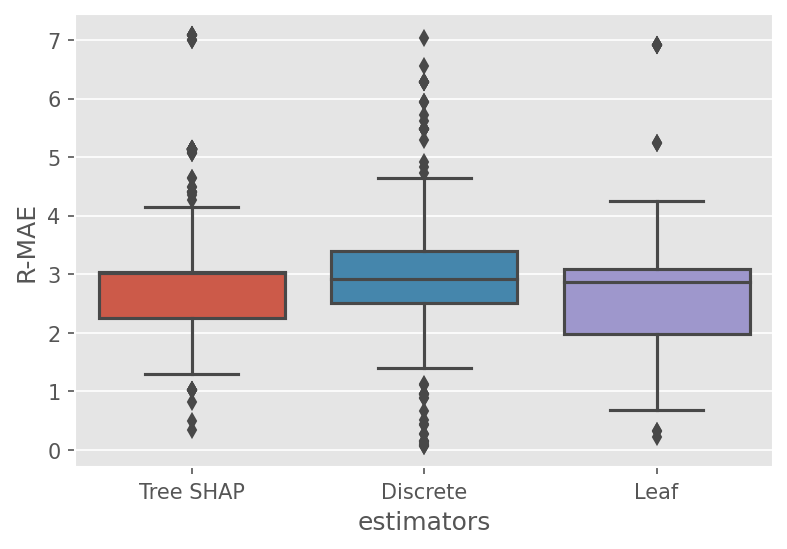

In [44]:
plug_sv = plug_sv.squeeze()
plug_sv_leaf = plug_sv_leaf.squeeze()
shap_sv = shap_sv.squeeze()
mc_sv = mc_sv.squeeze()
plug_sv_r = np.zeros(shape=mc_sv.shape)
shap_sv_r = np.zeros(shape=mc_sv.shape)
plug_sv_leaf_r = np.zeros(shape=mc_sv.shape)
for i in range(d):
    plug_sv_r[:, i] = plug_sv[:, C[i][0]]
    shap_sv_r[:, i] = shap_sv[:, C[i][0]]
    plug_sv_leaf_r[:, i] = plug_sv_leaf[:, C[i][0]]

sample_data = np.concatenate([shap_sv_r, plug_sv_r, plug_sv_leaf_r], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb * ['Tree SHAP'] + nb * ['Discrete'] + nb * ['Leaf']

relative = np.zeros(shape=mc_sv.shape)
for i in range(mc_sv.shape[0]):
    for j in range(mc_sv.shape[1]):
        if np.abs(mc_sv[i, j]) < 1:
            relative[i, j] = 1
        else:
            relative[i, j] = mc_sv[i, j]
            
err_monte_carlo = l1_norm((mc_sv- mc_sv)/relative)
err_plugin = l1_norm((plug_sv_r - mc_sv)/relative)
err_shap = l1_norm((shap_sv_r - mc_sv)/relative)
err_plugin_leaf = l1_norm((plug_sv_leaf_r - mc_sv)/relative)
err_concat = np.concatenate([err_shap, err_plugin, err_plugin_leaf], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [45]:
shap_dataFra.replace([np.inf, -np.inf], np.nan, inplace=True)
shap_dataFra.dropna(axis=0, inplace=True)
shap_dataFra.shape

(1500, 5)

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

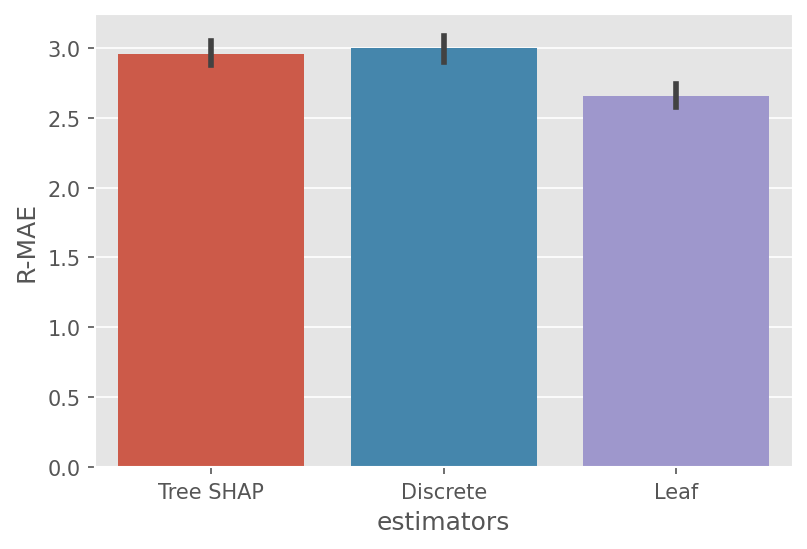

In [46]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE')

In [47]:
print('err_shap = {} -- err_plugin = {} - err_leaf = {}'.format(np.mean(err_shap), np.mean(err_plugin),
                                                                np.mean(err_plugin_leaf)))

err_shap = 2.958397270015674 -- err_plugin = 2.995507123297602 - err_leaf = 2.6537795569148575


In [48]:
from experiments import utils

mc_sv = mc_sv.squeeze()
shap_sv = shap_sv_r.squeeze()
plug_sv = plug_sv_r.squeeze()
plug_sv_leaf = plug_sv_leaf_r.squeeze()

def return_fi(sv, k=1):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv)
fi_shap = return_fi(shap_sv)
fi_plug = return_fi(plug_sv)
fi_plug_leaf = return_fi(plug_sv_leaf)

In [49]:
print('SHAP - TPR - std TPR - FDE - std FDR')

utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(29.799999702000008, 45.737948775177934, 70.19999929800001, 45.737948775177934)

In [50]:
print('Discrete - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Discrete - TPR - std TPR - FDE - std FDR


(65.799999342, 47.43795900956112, 34.199999658, 47.43795900956111)

In [51]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug_leaf)

Leaf - TPR - std TPR - FDE - std FDR


(36.999999630000005, 48.28043033548895, 62.99999937000001, 48.28043033548895)